In [32]:
%matplotlib inline

import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import multivariate_normal
import os
from dirichlet import simplex
from plot_utils import errorBars

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

os.chdir('/Users/sbittner/Documents/efn/');

appendix_fig = True;

exp_fam = 'dirichlet';
D = 25;
K_eta = 100;
M = 1000;
flow_id = '25P';
L = 5;
give_inv = False;

if (give_inv):
    give_inv_str = 'giveInv_';
else:
    give_inv_str = '';

basedir = '/Users/sbittner/Documents/efn/results/Fig3/';

modelstr = 'EFN_%s_stochasticEta_%sD=%d_K=%d_M=%d_flow=%s_L=%d_rs=0/' % \
                    (exp_fam, give_inv_str, D, K_eta, M, flow_id, L);

savedir = basedir + modelstr;
fname = savedir + 'results.npz';

X = np.load(fname);
nits = X['it'];

if (appendix_fig):
    R2s = X['test_R2s'];
    KLs = X['test_KLs'];
else:
    R2s = X['train_R2s'];
    KLs = X['train_KLs'];
check_diagnostic_rate = 100;
its = np.arange(nits);
fontsize = 20;



/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


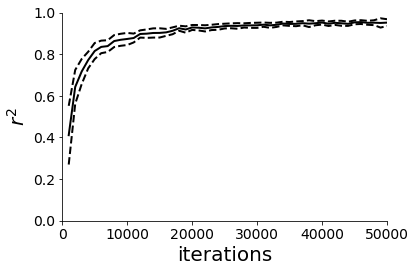

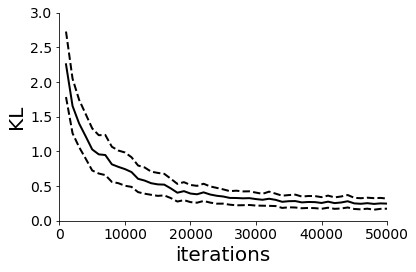

In [33]:
fontsize = 20;
N = 500;
K_eta = R2s.shape[1];
its = check_diagnostic_rate*np.arange(1,N+1, dtype=float);
R2s_mean = np.mean(R2s[:N,:], 1);
R2s_stderr = np.std(R2s[:N,:], 1);
KLs_mean = np.mean(KLs[:N,:], 1);
KLs_stderr = np.std(KLs[:N,:], 1);
fig = plt.figure(figsize=(16,10));

skip = 10;
its = its[np.arange(skip-1, N, skip)];
R2s_mean = R2s_mean[np.arange(skip-1, N, skip)];
R2s_stderr = R2s_stderr[np.arange(skip-1, N, skip)];
KLs_mean = KLs_mean[np.arange(skip-1, N, skip)];
KLs_stderr = KLs_stderr[np.arange(skip-1, N, skip)];

R2top_stderr = R2s_mean + R2s_stderr;
R2bot_stderr = R2s_mean - R2s_stderr;
KLtop_stderr = KLs_mean + KLs_stderr;
KLbot_stderr = KLs_mean - KLs_stderr;

plt.figure();
plt.plot(its, R2s_mean,'k', lw=2);
plt.plot(its, R2top_stderr,'k--', lw=2);
plt.plot(its, R2bot_stderr,'k--', lw=2);
plt.xlabel('iterations', fontsize=fontsize);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('$r^2$', fontsize=fontsize)
plt.xlim([0,check_diagnostic_rate*N]);
plt.ylim([0,1]);
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
if (appendix_fig):
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/figA1/A1a.pdf', dpi=300, transparent=True, )
else:
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig2/2a.pdf', dpi=300, transparent=True, )
plt.show();

plt.figure();
plt.plot(its, KLs_mean,'k', lw=2);
plt.plot(its, KLtop_stderr,'k--', lw=2);
plt.plot(its, KLbot_stderr,'k--', lw=2);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('KL', fontsize=fontsize)
plt.xlim([0,check_diagnostic_rate*N]);
plt.ylim([0,3]);
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
if (appendix_fig):
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/figA1/A1b.pdf', dpi=300, transparent=True, )
else:
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig2/2b.pdf', dpi=300, transparent=True, )
plt.show();



In [34]:
Z = X['X'];
eta = X['eta'];
params = X['params'][()];
D = params['D'];
alphas = params['alpha'];


In [35]:
def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

In [36]:
from scipy.stats import dirichlet

alpha = np.array([1,2,3]);
dist = dirichlet(alpha);
x = dist.rvs(100);
print(x.shape);

(100, 3)


In [37]:
from sklearn.metrics import pairwise_distances
from sys import stdout
from sklearn.metrics import pairwise_kernels

n = 50;
n_mmds = K_eta;
pvals = np.zeros((n_mmds,));
for ind in range(n_mmds):
    X = Z[ind,:n,:,0];
    alpha = alphas[ind];
    dist = dirichlet(alpha);
    Y = dist.rvs(n);
    print('r^2:', R2s[N-1,ind]);
    print('KL:', KLs[N-1,ind]);
    sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
    mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
                                                        kernel_function='rbf',
                                                        gamma=1.0/sigma2,
                                                        verbose=True)
    pvals[ind] = p_value;


r^2: 0.952610275766586
KL: 0.24021653107069835
MMD^2_u = 0.0025163379511371486
Computing the null distribution.
0
1000
2000
3000
4000
5000
6000
7000
8000
9000

p-value ~= 0.2626 	 (resolution : 0.0001)
r^2: 0.9496004650694814
KL: 0.26900260572279255
MMD^2_u = 0.00908946972559499
Computing the null distribution.
0
1000
2000


KeyboardInterrupt: 

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


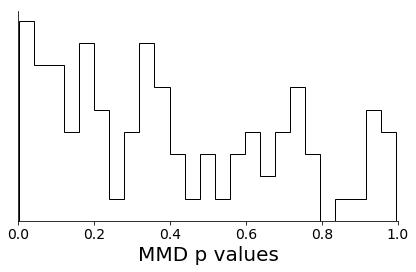

In [30]:
if (not appendix_fig):
    plt.figure();
    plt.hist(pvals, 25, histtype='step', normed=True, color='k');
    plt.xlabel('MMD p values', fontsize=fontsize);
    plt.xlim([0, 1]);
    ax = plt.gca();
    ax.set_yticks([]);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig2/2c.pdf', dpi=300, transparent=True, )
    plt.show();
